Detección de Anomalías con Mezclas Gaussianas y LOF en Python

In [2]:
# Instalación de librerías necesarias
!pip install kaggle scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# Cargar el dataset
# Asegúrate de que el archivo esté en el mismo directorio o proporciona la ruta completa
file_path = 'creditcard.csv'  # Cambia esto si tu archivo tiene otro nombre o está en otra ubicación

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset cargado exitosamente")
except FileNotFoundError:
    print("❌ Archivo no encontrado. Por favor, verifica:")
    print("1. Que el archivo 'creditcard.csv' esté en el directorio actual")
    print("2. O proporciona la ruta completa")

    # Si usas Google Colab, puedes subir el archivo:
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    df = pd.read_csv(file_name)

print("="*80)
print("ANÁLISIS DE DETECCIÓN DE ANOMALÍAS - CREDIT CARD FRAUD DATASET")
print("="*80)
print(f"\n📊 Dimensiones del dataset: {df.shape}")
print(f"📈 Número de transacciones: {len(df):,}")
print(f"🎯 Número de características: {len(df.columns)}")

# Mostrar información básica
print("\n🔍 Primeras 5 filas:")
print(df.head())

print("\n📋 Información del dataset:")
print(df.info())

print("\n📊 Estadísticas descriptivas:")
print(df.describe())

✅ Dataset cargado exitosamente
ANÁLISIS DE DETECCIÓN DE ANOMALÍAS - CREDIT CARD FRAUD DATASET

📊 Dimensiones del dataset: (7973, 31)
📈 Número de transacciones: 7,973
🎯 Número de características: 31

🔍 Primeras 5 filas:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.9094


DISTRIBUCIÓN DE CLASES
💳 Transacciones normales (Class=0): 7,947 (99.6864%)
🚨 Transacciones fraudulentas (Class=1): 25 (0.3136%)


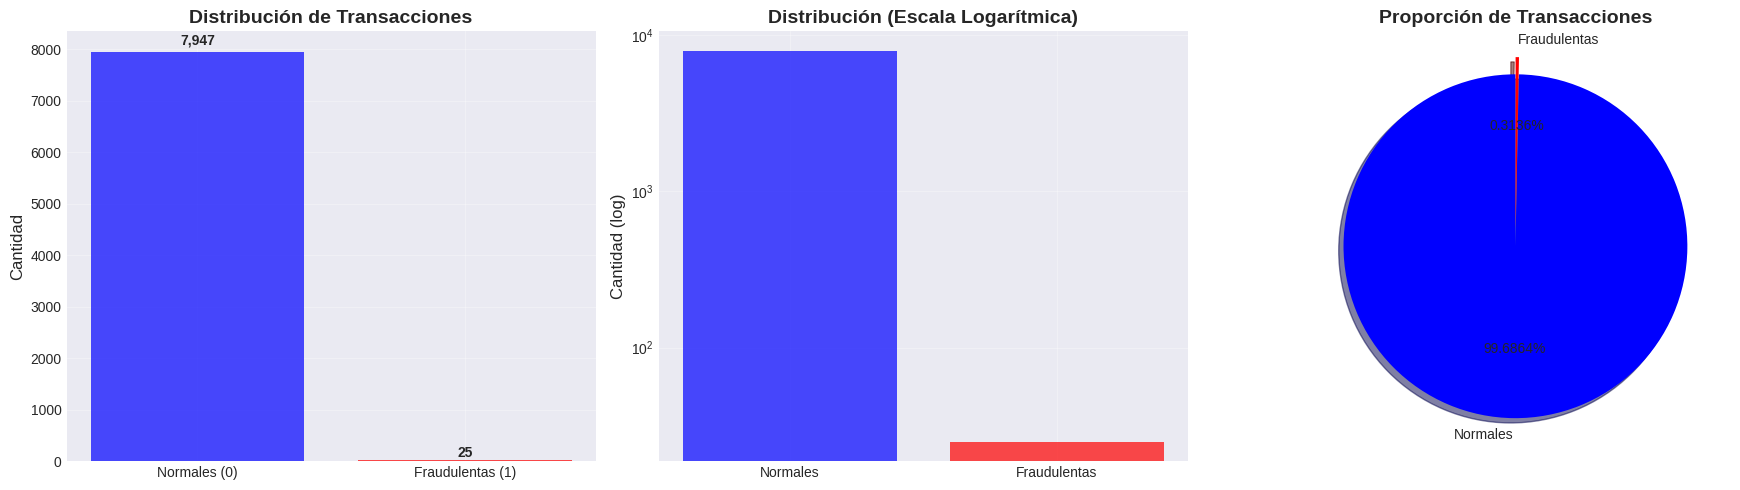


🎯 Características disponibles: 30
📝 Nombres: Time, V1, V2, V3, V4...


In [7]:
# Analizar la distribución de clases
print("\n" + "="*60)
print("DISTRIBUCIÓN DE CLASES")
print("="*60)

class_dist = df['Class'].value_counts()
class_dist_pct = df['Class'].value_counts(normalize=True) * 100

print(f"💳 Transacciones normales (Class=0): {class_dist[0]:,} ({class_dist_pct[0]:.4f}%)")
print(f"🚨 Transacciones fraudulentas (Class=1): {class_dist[1]:,} ({class_dist_pct[1]:.4f}%)")

# Visualizar distribución de clases
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de barras normal
axes[0].bar(['Normales (0)', 'Fraudulentas (1)'], [class_dist[0], class_dist[1]],
            color=['blue', 'red'], alpha=0.7)
axes[0].set_title('Distribución de Transacciones', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Añadir valores encima de las barras
for i, v in enumerate([class_dist[0], class_dist[1]]):
    axes[0].text(i, v*1.01, f'{v:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gráfico de barras en escala logarítmica
axes[1].bar(['Normales', 'Fraudulentas'], [class_dist[0], class_dist[1]],
           color=['blue', 'red'], alpha=0.7)
axes[1].set_title('Distribución (Escala Logarítmica)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cantidad (log)', fontsize=12)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Gráfico de pastel
axes[2].pie([class_dist[0], class_dist[1]],
           labels=['Normales', 'Fraudulentas'],
           colors=['blue', 'red'],
           autopct='%1.4f%%',
           explode=[0, 0.1],
           startangle=90,
           shadow=True)
axes[2].set_title('Proporción de Transacciones', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Separar características y etiquetas
X = df.drop('Class', axis=1)
y = df['Class']
feature_names = X.columns.tolist()

print(f"\n🎯 Características disponibles: {len(feature_names)}")
print(f"📝 Nombres: {', '.join(feature_names[:5])}...")  # Mostrar solo las primeras 5



ANÁLISIS DE CARACTERÍSTICAS 'Time' y 'Amount'


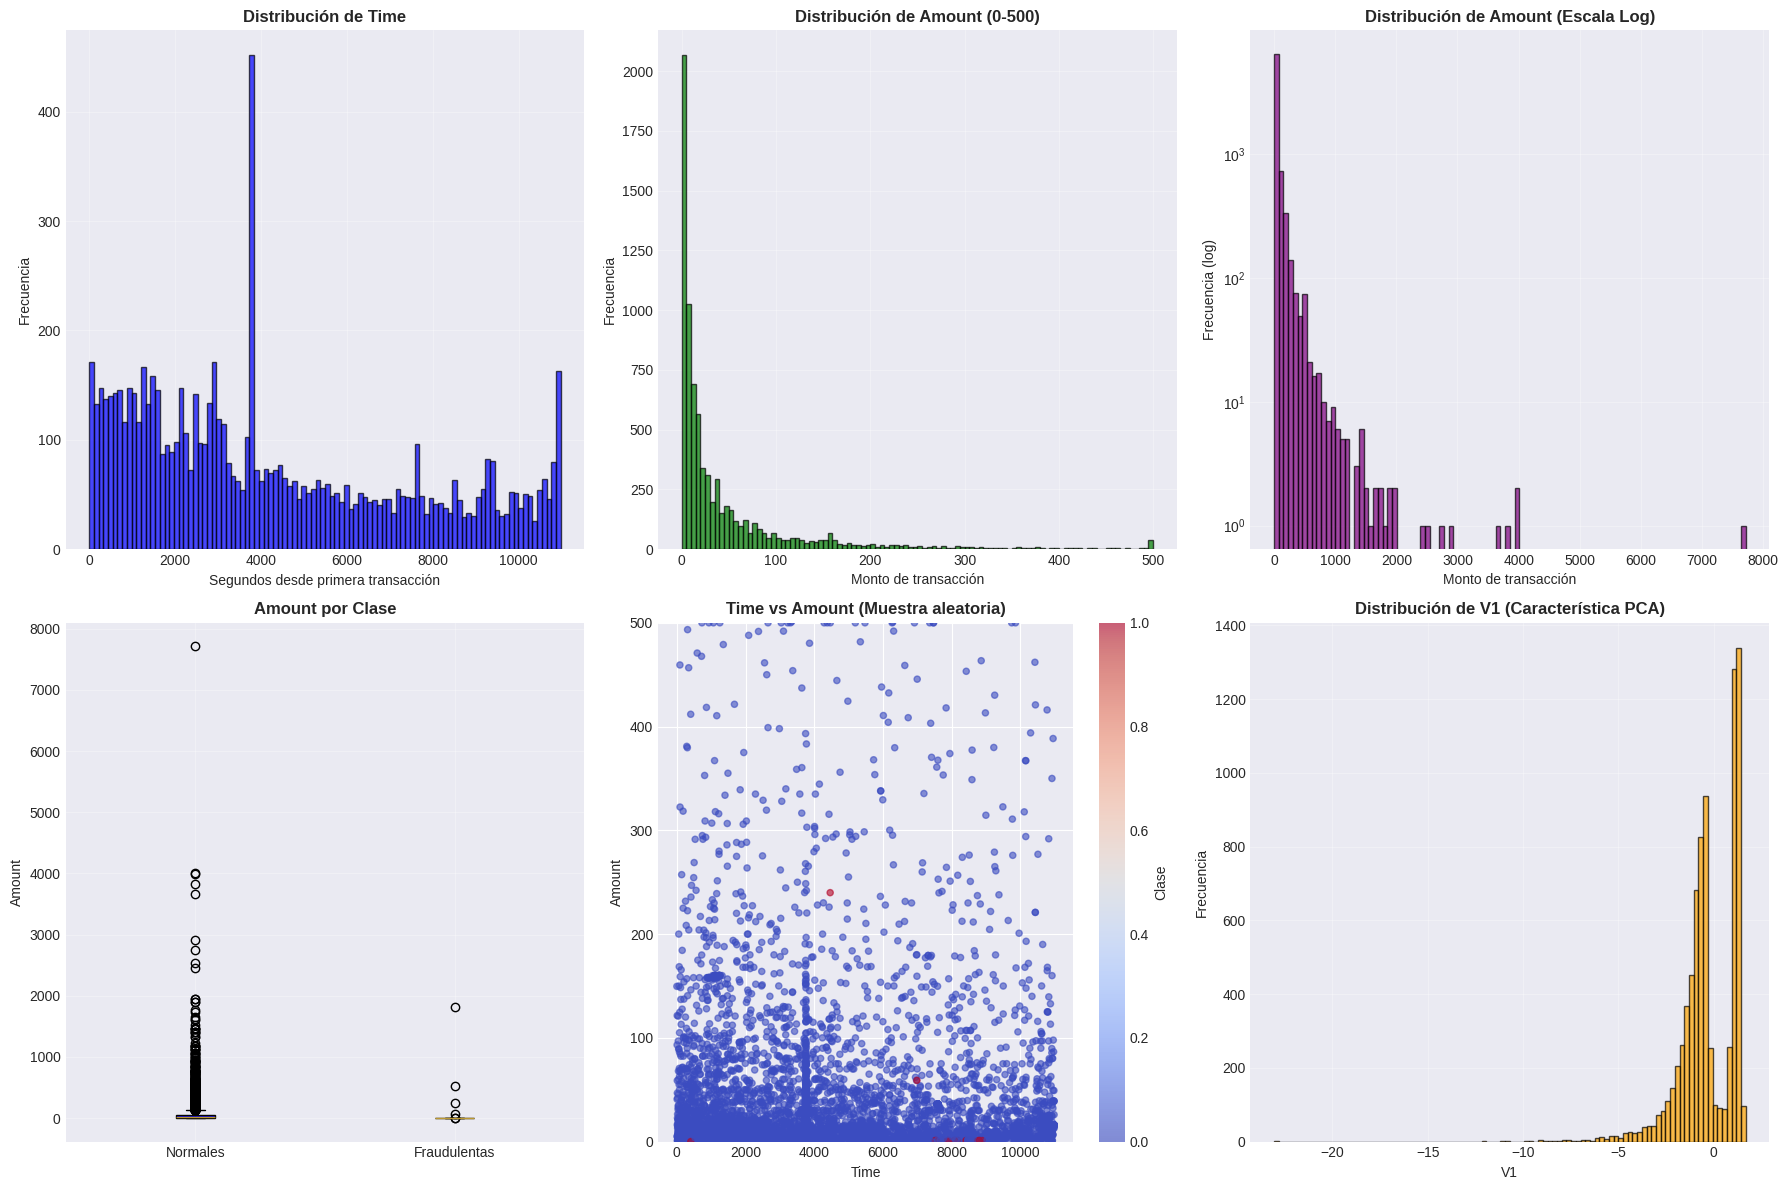


📊 Estadísticas de Amount por clase:

💳 Transacciones Normales:
count    7947.000000
mean       65.284891
std       194.126547
min         0.000000
25%         4.795000
50%        15.950000
75%        54.990000
max      7712.430000
Name: Amount, dtype: float64

🚨 Transacciones Fraudulentas:
count      25.000000
mean      106.308400
std       372.676883
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1809.680000
Name: Amount, dtype: float64


In [8]:
# Análisis de las características más importantes
print("\n" + "="*60)
print("ANÁLISIS DE CARACTERÍSTICAS 'Time' y 'Amount'")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de Time
axes[0, 0].hist(df['Time'], bins=100, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Distribución de Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Segundos desde primera transacción')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Distribución de Amount (zoom en la mayoría de datos)
axes[0, 1].hist(df['Amount'], bins=100, alpha=0.7, color='green', edgecolor='black', range=(0, 500))
axes[0, 1].set_title('Distribución de Amount (0-500)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Monto de transacción')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de Amount (escala logarítmica)
axes[0, 2].hist(df['Amount'], bins=100, alpha=0.7, color='purple', edgecolor='black', log=True)
axes[0, 2].set_title('Distribución de Amount (Escala Log)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Monto de transacción')
axes[0, 2].set_ylabel('Frecuencia (log)')
axes[0, 2].grid(True, alpha=0.3)

# Boxplot de Amount por clase
bp = axes[1, 0].boxplot([df[df['Class']==0]['Amount'].sample(min(10000, len(df[df['Class']==0])), random_state=42),
                         df[df['Class']==1]['Amount']],
                        labels=['Normales', 'Fraudulentas'],
                        patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('red')
axes[1, 0].set_title('Amount por Clase', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Amount')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot de Time vs Amount
scatter = axes[1, 1].scatter(df['Time'].sample(min(5000, len(df)), random_state=42),
                            df['Amount'].sample(min(5000, len(df)), random_state=42),
                            c=df['Class'].sample(min(5000, len(df)), random_state=42),
                            cmap='coolwarm',
                            alpha=0.6,
                            s=20)
axes[1, 1].set_title('Time vs Amount (Muestra aleatoria)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Amount')
axes[1, 1].set_ylim([0, 500])
plt.colorbar(scatter, ax=axes[1, 1], label='Clase')

# Distribución de V1 (ejemplo de características PCA)
axes[1, 2].hist(df['V1'], bins=100, alpha=0.7, color='orange', edgecolor='black')
axes[1, 2].set_title('Distribución de V1 (Característica PCA)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('V1')
axes[1, 2].set_ylabel('Frecuencia')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de Amount por clase
print("\n📊 Estadísticas de Amount por clase:")
print("\n💳 Transacciones Normales:")
print(df[df['Class']==0]['Amount'].describe())
print("\n🚨 Transacciones Fraudulentas:")
print(df[df['Class']==1]['Amount'].describe())

In [10]:
print("\n" + "="*60)
print("PREPROCESAMIENTO DE DATOS")
print("="*60)

# Las características V1-V28 ya están escaladas con PCA
# Solo necesitamos escalar Time y Amount
scaler = RobustScaler()  # Usamos RobustScaler porque es más resistente a outliers

# Crear copia del dataframe para escalar
df_scaled = df.copy()

# Escalar Time y Amount
df_scaled[['Time', 'Amount']] = scaler.fit_transform(df_scaled[['Time', 'Amount']])

# Preparar datos para modelado
X_scaled = df_scaled.drop('Class', axis=1).values
y_true = df_scaled['Class'].values

print(f"✅ Datos escalados correctamente")
print(f"📐 Dimensiones de X: {X_scaled.shape}")
print(f"🎯 Dimensiones de y: {y_true.shape}")
print(f"🔢 Valores únicos en y: {np.unique(y_true, return_counts=True)}")


PREPROCESAMIENTO DE DATOS
✅ Datos escalados correctamente
📐 Dimensiones de X: (7973, 30)
🎯 Dimensiones de y: (7973,)
🔢 Valores únicos en y: (array([ 0.,  1., nan]), array([7947,   25,    1]))


Método 1: Mezclas Gaussianas (GMM)

In [12]:
print("\n" + "="*80)
print("MÉTODO 1: MEZCLAS GAUSSIANAS (GMM) PARA DETECCIÓN DE ANOMALÍAS")
print("="*80)

def gmm_anomaly_detection(X, y_true=None, n_components=3, contamination=0.01, random_state=42):
    """
    Implementación de detección de anomalías usando GMM
    """
    print(f"\n🔧 Configuración GMM:")
    print(f"   - Componentes Gaussianas: {n_components}")
    print(f"   - Contaminación esperada: {contamination*100:.2f}%")

    # Eliminar filas con NaN para que GMM pueda procesar los datos
    if np.isnan(X).any():
        nan_rows = np.any(np.isnan(X), axis=1)
        original_X_len = len(X)
        X = X[~nan_rows]
        if y_true is not None:
            y_true = y_true[~nan_rows]
        print(f"   - Se eliminaron {original_X_len - len(X)} filas con valores NaN. Nuevo tamaño de X: {len(X)}")

    # Submuestreo para manejar el desbalance
    if len(X) > 50000:
        # Para datasets grandes, usamos una muestra
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X, y_true if y_true is not None else np.zeros(len(X)),
            test_size=0.7,
            stratify=y_true if y_true is not None else None,
            random_state=random_state
        )
        print(f"   - Muestra usada para entrenamiento: {len(X_sample):,} de {len(X):,}")
    else:
        X_sample = X
        y_sample = y_true

    # Ajustar el modelo GMM
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type='full',
        max_iter=200,
        random_state=random_state,
        n_init=3
    )

    gmm.fit(X_sample)

    # Calcular puntuaciones (log probabilities negativas)
    log_probs = gmm.score_samples(X)
    scores = -log_probs  # Convertir a puntuación positiva (mayor = más anómalo)

    # Determinar umbral basado en la contaminación esperada
    threshold = np.percentile(scores, 100 * (1 - contamination))

    # Predecir anomalías
    predictions = (scores > threshold).astype(int)

    # Calcular métricas si tenemos valores verdaderos
    if y_true is not None:
        tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

        print(f"\n📊 Resultados GMM:")
        print(f"   - Verdaderos Negativos: {tn:,}")
        print(f"   - Falsos Positivos: {fp:,}")
        print(f"   - Falsos Negativos: {fn:,}")
        print(f"   - Verdaderos Positivos: {tp:,}")

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n🎯 Métricas de Evaluación:")
        print(f"   - Exactitud: {accuracy:.4f}")
        print(f"   - Precisión: {precision:.4f}")
        print(f"   - Recall: {recall:.4f}")
        print(f"   - F1-Score: {f1:.4f}")

    print(f"\n📈 Estadísticas del Modelo:")
    print(f"   - Total de puntos: {len(X):,}")
    print(f"   - Anomalías detectadas: {np.sum(predictions):,} ({np.sum(predictions)/len(X)*100:.4f}%)")
    print(f"   - Umbral de puntuación: {threshold:.4f}")
    print(f"   - BIC: {gmm.bic(X_sample):.2f}")
    print(f"   - AIC: {gmm.aic(X_sample):.2f}")
    print(f"   - Convergió: {'Sí' if gmm.converged_ else 'No'}")

    return predictions, scores, gmm, threshold

# Aplicar GMM
gmm_predictions, gmm_scores, gmm_model, gmm_threshold = gmm_anomaly_detection(
    X_scaled,
    y_true,
    n_components=3,
    contamination=0.02  # Esperamos ~2% de anomalías
)


MÉTODO 1: MEZCLAS GAUSSIANAS (GMM) PARA DETECCIÓN DE ANOMALÍAS

🔧 Configuración GMM:
   - Componentes Gaussianas: 3
   - Contaminación esperada: 2.00%
   - Se eliminaron 1 filas con valores NaN. Nuevo tamaño de X: 7972

📊 Resultados GMM:
   - Verdaderos Negativos: 7,811
   - Falsos Positivos: 136
   - Falsos Negativos: 1
   - Verdaderos Positivos: 24

🎯 Métricas de Evaluación:
   - Exactitud: 0.9828
   - Precisión: 0.1500
   - Recall: 0.9600
   - F1-Score: 0.2595

📈 Estadísticas del Modelo:
   - Total de puntos: 7,972
   - Anomalías detectadas: 160 (2.0070%)
   - Umbral de puntuación: 54.6173
   - BIC: 164900.42
   - AIC: 154515.67
   - Convergió: Sí


Método 2: Local Outlier Factor (LOF)

In [15]:
print("\n" + "="*80)
print("MÉTODO 2: LOCAL OUTLIER FACTOR (LOF) PARA DETECCIÓN DE ANOMALÍAS")
print("="*80)

def lof_anomaly_detection(X, y_true=None, n_neighbors=50, contamination='auto', random_state=42):
    """
    Implementación de detección de anomalías usando LOF
    """
    print(f"\n🔧 Configuración LOF:")
    print(f"   - Número de vecinos: {n_neighbors}")
    print(f"   - Contaminación: {contamination}")

    # Eliminar filas con NaN para que LOF pueda procesar los datos
    if np.isnan(X).any():
        nan_rows = np.any(np.isnan(X), axis=1)
        original_X_len = len(X)
        X = X[~nan_rows]
        if y_true is not None:
            y_true = y_true[~nan_rows]
        print(f"   - Se eliminaron {original_X_len - len(X)} filas con valores NaN. Nuevo tamaño de X: {len(X)}")

    # Para datasets grandes, usar una muestra para ajustar hiperparámetros
    if len(X) > 50000:
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X, y_true if y_true is not None else np.zeros(len(X)),
            test_size=0.9,
            random_state=random_state
        )
        print(f"   - Muestra usada: {len(X_sample):,} de {len(X):,}")
    else:
        X_sample = X
        y_sample = y_true

    # Aplicar LOF
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False,  # Para detección sin necesidad de train/test split
        n_jobs=-1,      # Usar todos los cores disponibles
        metric='euclidean'
    )

    # Predecir anomalías
    predictions = lof.fit_predict(X_sample)

    # Convertir a 0/1 (1 = anomalía)
    predictions_binary = (predictions == -1).astype(int)

    # Obtener puntuaciones
    scores = -lof.negative_outlier_factor_

    # Si usamos muestra, predecir en todo el dataset
    if len(X_sample) < len(X):
        # Para predecir en todo el dataset necesitamos usar el modo novelty
        lof_novelty = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )
        lof_novelty.fit(X_sample)
        predictions_full = lof_novelty.predict(X)
        predictions_binary = (predictions_full == -1).astype(int)
        scores = -lof_novelty.score_samples(X)  # Puntuaciones negativas

    # Calcular métricas si tenemos valores verdaderos
    if y_true is not None:
        # Para predicción completa
        if len(predictions_binary) == len(y_true):
            tn, fp, fn, tp = confusion_matrix(y_true, predictions_binary).ravel()

            print(f"\n📊 Resultados LOF:")
            print(f"   - Verdaderos Negativos: {tn:,}")
            print(f"   - Falsos Positivos: {fp:,}")
            print(f"   - Falsos Negativos: {fn:,}")
            print(f"   - Verdaderos Positivos: {tp:,}")

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            print(f"\n🎯 Métricas de Evaluación:")
            print(f"   - Exactitud: {accuracy:.4f}")
            print(f"   - Precisión: {precision:.4f}")
            print(f"   - Recall: {recall:.4f}")
            print(f"   - F1-Score: {f1:.4f}")

    print(f"\n📈 Estadísticas del Modelo:")
    print(f"   - Total de puntos: {len(predictions_binary):,}")
    print(f"   - Anomalías detectadas: {np.sum(predictions_binary):,} ({np.sum(predictions_binary)/len(predictions_binary)*100:.4f}%)")
    print(f"   - Puntuación LOF promedio: {np.mean(scores):.4f}")
    print(f"   - Puntuación LOF máxima: {np.max(scores):.4f}")

    return predictions_binary, scores, lof

# Aplicar LOF
lof_predictions, lof_scores, lof_model = lof_anomaly_detection(
    X_scaled,
    y_true,
    n_neighbors=100,  # Más vecinos para dataset grande
    contamination=0.0017  # Basado en proporción real de fraudes
)


MÉTODO 2: LOCAL OUTLIER FACTOR (LOF) PARA DETECCIÓN DE ANOMALÍAS

🔧 Configuración LOF:
   - Número de vecinos: 100
   - Contaminación: 0.0017
   - Se eliminaron 1 filas con valores NaN. Nuevo tamaño de X: 7972

📊 Resultados LOF:
   - Verdaderos Negativos: 7,935
   - Falsos Positivos: 12
   - Falsos Negativos: 23
   - Verdaderos Positivos: 2

🎯 Métricas de Evaluación:
   - Exactitud: 0.9956
   - Precisión: 0.1429
   - Recall: 0.0800
   - F1-Score: 0.1026

📈 Estadísticas del Modelo:
   - Total de puntos: 7,972
   - Anomalías detectadas: 14 (0.1756%)
   - Puntuación LOF promedio: 1.1964
   - Puntuación LOF máxima: 12.1519


Visualización de resultados


VISUALIZACIÓN DE RESULTADOS
   - Se eliminaron 1 filas con valores NaN para visualización.

🔍 Aplicando PCA para visualización 2D...
📊 Varianza explicada por componentes PCA: [0.36450846 0.09415506]
📈 Varianza total explicada: 0.4587


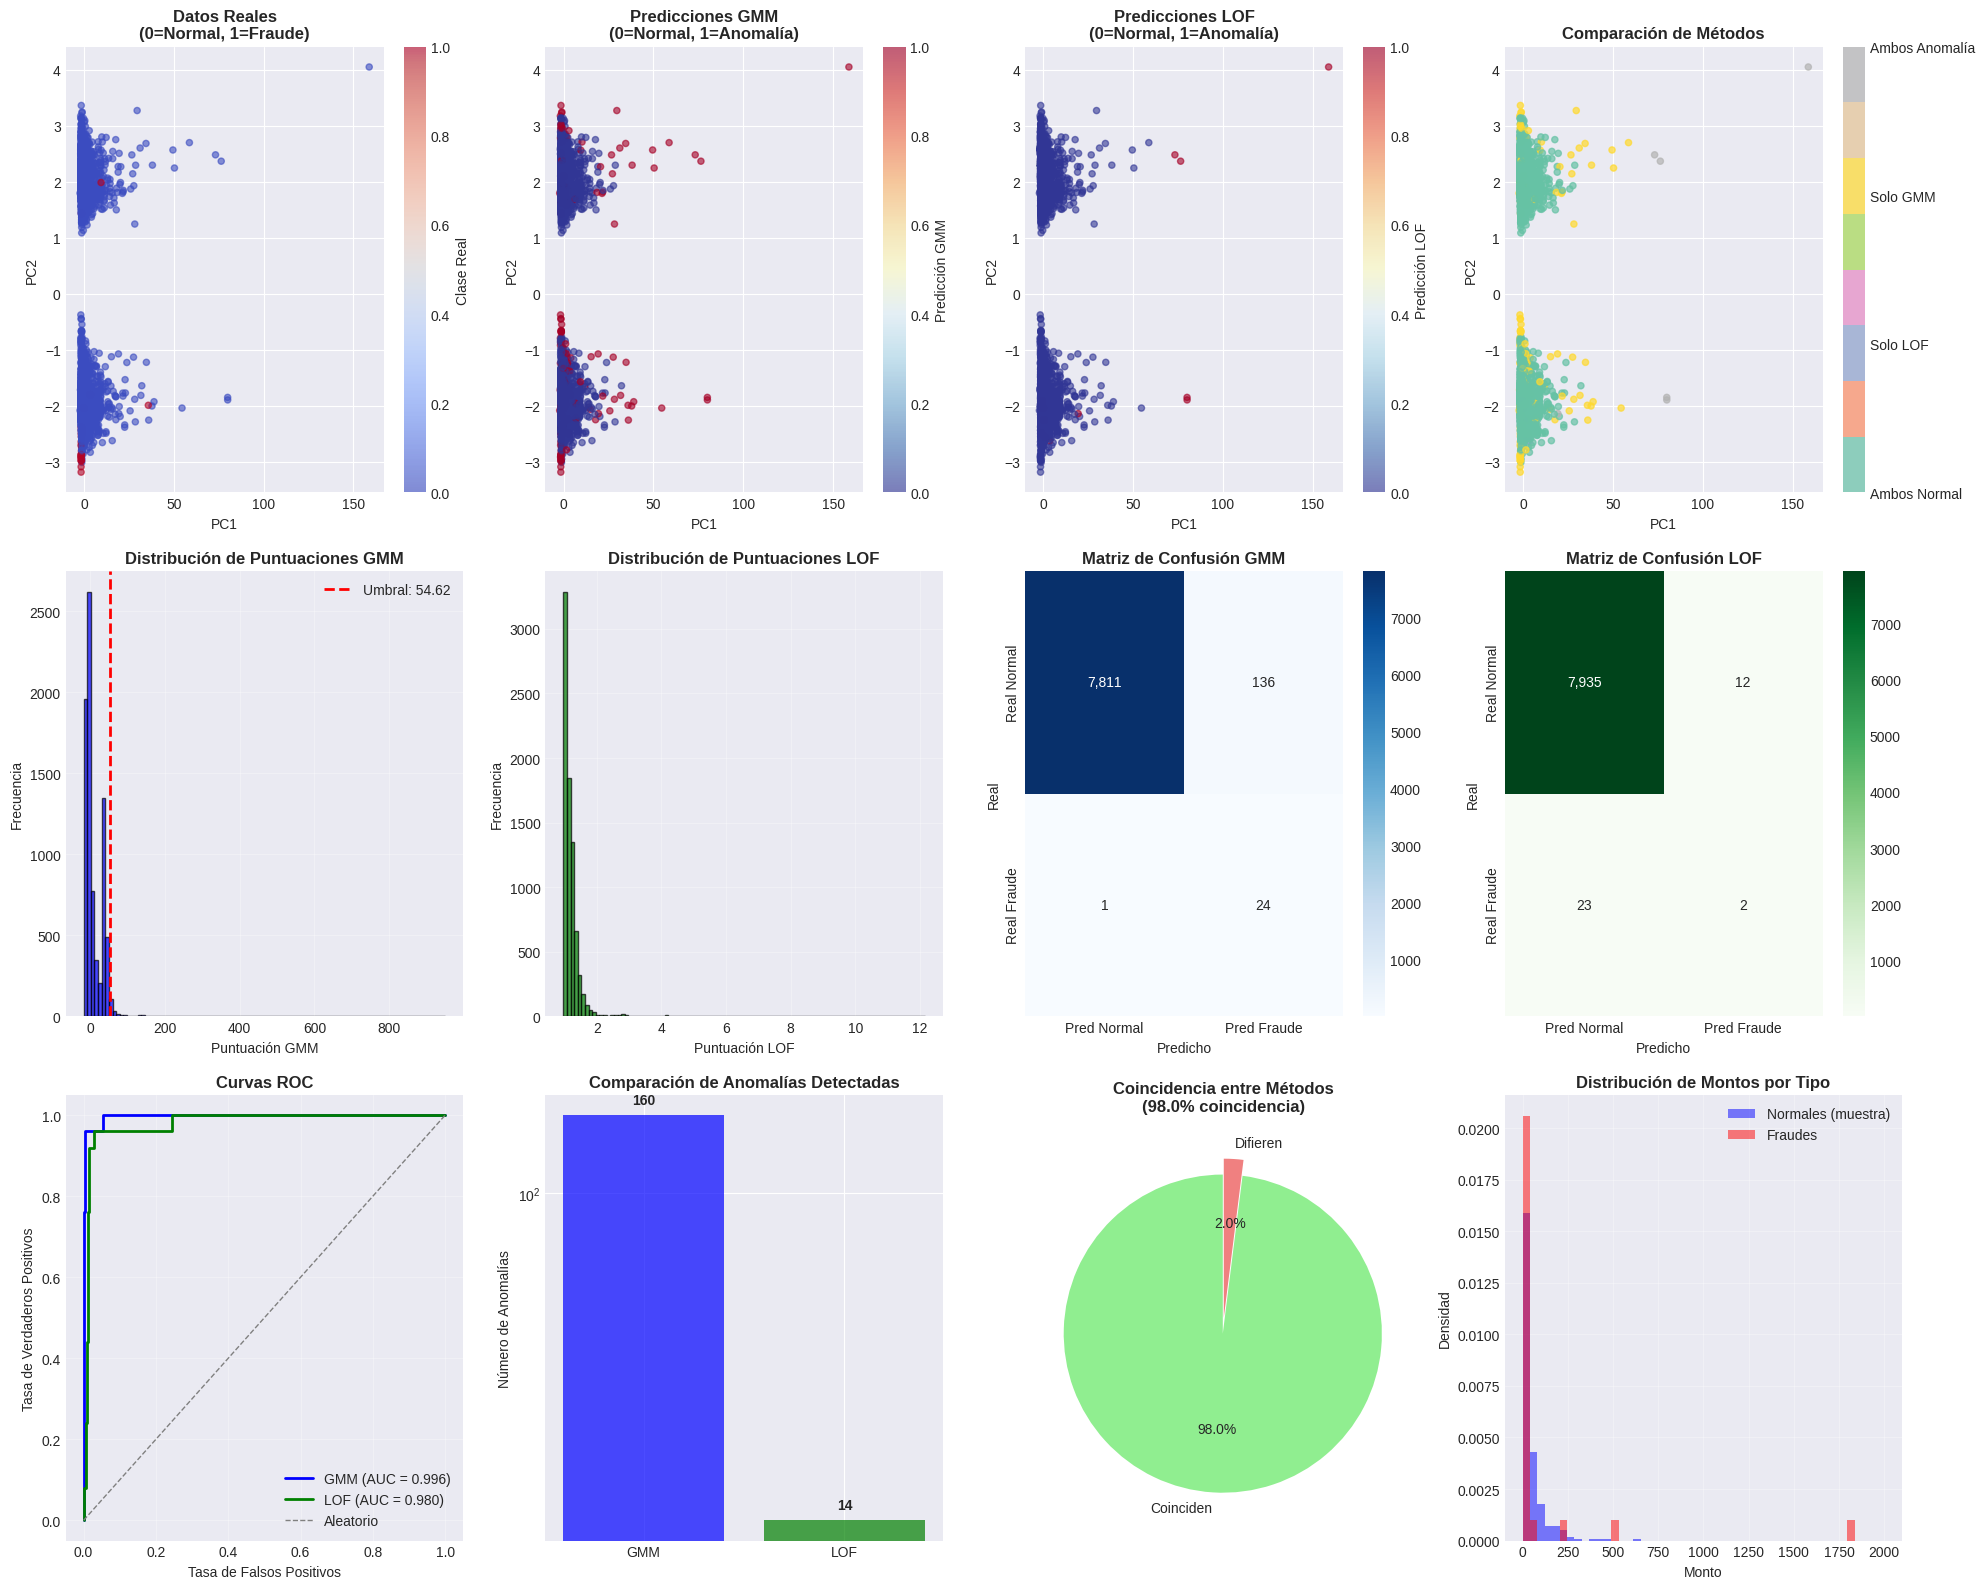

In [17]:
print("\n" + "="*80)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*80)

# Eliminar filas con NaN de X_scaled y y_true para la visualización
# Esta operación ya se hizo localmente dentro de las funciones GMM y LOF,
# pero X_scaled y y_true globales aún contienen el NaN.
initial_len_X_scaled = len(X_scaled)
nan_rows_X = np.any(np.isnan(X_scaled), axis=1)
X_scaled_cleaned = X_scaled[~nan_rows_X]
y_true_cleaned = y_true[~nan_rows_X]

if initial_len_X_scaled - len(X_scaled_cleaned) > 0:
    print(f"   - Se eliminaron {initial_len_X_scaled - len(X_scaled_cleaned)} filas con valores NaN para visualización.")


# Reducción de dimensionalidad para visualización
print("\n🔍 Aplicando PCA para visualización 2D...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_cleaned)

print(f"📊 Varianza explicada por componentes PCA: {pca.explained_variance_ratio_}")
print(f"📈 Varianza total explicada: {sum(pca.explained_variance_ratio_):.4f}")

# Crear dataframe para visualización
vis_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Class': y_true_cleaned,
    'GMM_Pred': gmm_predictions,
    'LOF_Pred': lof_predictions,
    'GMM_Score': gmm_scores,
    'LOF_Score': lof_scores
})

# Tomar una muestra para visualización (máximo 10,000 puntos)
sample_size = min(10000, len(vis_df))
vis_sample = vis_df.sample(sample_size, random_state=42)

fig = plt.figure(figsize=(20, 16))

# 1. Datos reales
ax1 = plt.subplot(3, 4, 1)
scatter1 = ax1.scatter(vis_sample['PC1'], vis_sample['PC2'],
                      c=vis_sample['Class'], cmap='coolwarm', alpha=0.6, s=20)
ax1.set_title('Datos Reales\n(0=Normal, 1=Fraude)', fontsize=12, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
plt.colorbar(scatter1, ax=ax1, label='Clase Real')

# 2. Predicciones GMM
ax2 = plt.subplot(3, 4, 2)
scatter2 = ax2.scatter(vis_sample['PC1'], vis_sample['PC2'],
                      c=vis_sample['GMM_Pred'], cmap='RdYlBu_r', alpha=0.6, s=20)
ax2.set_title('Predicciones GMM\n(0=Normal, 1=Anomalía)', fontsize=12, fontweight='bold')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.colorbar(scatter2, ax=ax2, label='Predicción GMM')

# 3. Predicciones LOF
ax3 = plt.subplot(3, 4, 3)
scatter3 = ax3.scatter(vis_sample['PC1'], vis_sample['PC2'],
                      c=vis_sample['LOF_Pred'], cmap='RdYlBu_r', alpha=0.6, s=20)
ax3.set_title('Predicciones LOF\n(0=Normal, 1=Anomalía)', fontsize=12, fontweight='bold')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
plt.colorbar(scatter3, ax=ax3, label='Predicción LOF')

# 4. Comparación de métodos
ax4 = plt.subplot(3, 4, 4)
# Codificar: 0=ambos normales, 1=solo GMM, 2=solo LOF, 3=ambos anomalía
comparison = np.zeros(len(vis_sample))
comparison[(vis_sample['GMM_Pred'] == 0) & (vis_sample['LOF_Pred'] == 1)] = 1
comparison[(vis_sample['GMM_Pred'] == 1) & (vis_sample['LOF_Pred'] == 0)] = 2
comparison[(vis_sample['GMM_Pred'] == 1) & (vis_sample['LOF_Pred'] == 1)] = 3

scatter4 = ax4.scatter(vis_sample['PC1'], vis_sample['PC2'],
                      c=comparison, cmap='Set2', alpha=0.7, s=20)
ax4.set_title('Comparación de Métodos', fontsize=12, fontweight='bold')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
cbar = plt.colorbar(scatter4, ax=ax4, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Ambos Normal', 'Solo LOF', 'Solo GMM', 'Ambos Anomalía'])

# 5. Distribución de puntuaciones GMM
ax5 = plt.subplot(3, 4, 5)
ax5.hist(vis_df['GMM_Score'], bins=100, alpha=0.7, color='blue', edgecolor='black')
ax5.axvline(x=gmm_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral: {gmm_threshold:.2f}')
ax5.set_title('Distribución de Puntuaciones GMM', fontsize=12, fontweight='bold')
ax5.set_xlabel('Puntuación GMM')
ax5.set_ylabel('Frecuencia')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Distribución de puntuaciones LOF
ax6 = plt.subplot(3, 4, 6)
ax6.hist(vis_df['LOF_Score'], bins=100, alpha=0.7, color='green', edgecolor='black')
ax6.set_title('Distribución de Puntuaciones LOF', fontsize=12, fontweight='bold')
ax6.set_xlabel('Puntuación LOF')
ax6.set_ylabel('Frecuencia')
ax6.grid(True, alpha=0.3)

# 7. Matriz de confusión GMM
ax7 = plt.subplot(3, 4, 7)
cm_gmm = confusion_matrix(y_true_cleaned, gmm_predictions)
sns.heatmap(cm_gmm, annot=True, fmt=',', cmap='Blues', ax=ax7,
            xticklabels=['Pred Normal', 'Pred Fraude'],
            yticklabels=['Real Normal', 'Real Fraude'])
ax7.set_title('Matriz de Confusión GMM', fontsize=12, fontweight='bold')
ax7.set_ylabel('Real')
ax7.set_xlabel('Predicho')

# 8. Matriz de confusión LOF
ax8 = plt.subplot(3, 4, 8)
cm_lof = confusion_matrix(y_true_cleaned, lof_predictions)
sns.heatmap(cm_lof, annot=True, fmt=',', cmap='Greens', ax=ax8,
            xticklabels=['Pred Normal', 'Pred Fraude'],
            yticklabels=['Real Normal', 'Real Fraude'])
ax8.set_title('Matriz de Confusión LOF', fontsize=12, fontweight='bold')
ax8.set_ylabel('Real')
ax8.set_xlabel('Predicho')

# 9. Curvas ROC (si es posible)
ax9 = plt.subplot(3, 4, 9)
# Asegurarse de que las longitudes coincidan después de la limpieza
if len(gmm_predictions) == len(y_true_cleaned):
    fpr_gmm, tpr_gmm, _ = roc_curve(y_true_cleaned, gmm_scores)
    roc_auc_gmm = auc(fpr_gmm, tpr_gmm)
    ax9.plot(fpr_gmm, tpr_gmm, color='blue', lw=2, label=f'GMM (AUC = {roc_auc_gmm:.3f})')

if len(lof_predictions) == len(y_true_cleaned):
    fpr_lof, tpr_lof, _ = roc_curve(y_true_cleaned, lof_scores)
    roc_auc_lof = auc(fpr_lof, tpr_lof)
    ax9.plot(fpr_lof, tpr_lof, color='green', lw=2, label=f'LOF (AUC = {roc_auc_lof:.3f})')

ax9.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Aleatorio')
ax9.set_title('Curvas ROC', fontsize=12, fontweight='bold')
ax9.set_xlabel('Tasa de Falsos Positivos')
ax9.set_ylabel('Tasa de Verdaderos Positivos')
ax9.legend(loc='lower right')
ax9.grid(True, alpha=0.3)

# 10. Comparación de detecciones
ax10 = plt.subplot(3, 4, 10)
methods_comparison = pd.DataFrame({
    'Método': ['GMM', 'LOF'],
    'Anomalías Detectadas': [np.sum(gmm_predictions), np.sum(lof_predictions)],
    'Porcentaje': [np.sum(gmm_predictions)/len(gmm_predictions)*100,
                   np.sum(lof_predictions)/len(lof_predictions)*100]
})
bars = ax10.bar(methods_comparison['Método'], methods_comparison['Anomalías Detectadas'],
               color=['blue', 'green'], alpha=0.7)
ax10.set_title('Comparación de Anomalías Detectadas', fontsize=12, fontweight='bold')
ax10.set_ylabel('Número de Anomalías')
ax10.set_yscale('log')

# Añadir valores en las barras
for bar, val in zip(bars, methods_comparison['Anomalías Detectadas']):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height*1.05,
             f'{val:,}', ha='center', va='bottom', fontweight='bold')

# 11. Coincidencia entre métodos
ax11 = plt.subplot(3, 4, 11)
if len(gmm_predictions) == len(lof_predictions):
    agreement = np.sum(gmm_predictions == lof_predictions) / len(gmm_predictions) * 100
    labels = ['Coinciden', 'Difieren']
    sizes = [agreement, 100 - agreement]
    colors = ['lightgreen', 'lightcoral']
    ax11.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=[0.1, 0])
    ax11.set_title(f'Coincidencia entre Métodos\n({agreement:.1f}% coincidencia)',
                  fontsize=12, fontweight='bold')
else:
    ax11.text(0.5, 0.5, 'Longitudes diferentes\nNo comparable',
             ha='center', va='center', fontsize=12)
    ax11.set_title('Comparación no disponible', fontsize=12, fontweight='bold')

# 12. Anomalías por monto de transacción
ax12 = plt.subplot(3, 4, 12)
fraud_amounts = df[df['Class']==1]['Amount']
normal_amounts = df[df['Class']==0]['Amount'].sample(len(fraud_amounts)*10, random_state=42)

bins = np.linspace(0, 2000, 50)
ax12.hist(normal_amounts, bins=bins, alpha=0.5, color='blue', label='Normales (muestra)', density=True)
ax12.hist(fraud_amounts, bins=bins, alpha=0.5, color='red', label='Fraudes', density=True)
ax12.set_title('Distribución de Montos por Tipo', fontsize=12, fontweight='bold')
ax12.set_xlabel('Monto')
ax12.set_ylabel('Densidad')
ax12.legend()
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()